In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv("Formula1_2025Season_RaceResults.csv")

df.head()

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Set Fastest Lap,Fastest Lap Time
0,Australia,1,4,Lando Norris,McLaren Mercedes,1,57,1:42:06.304,25,Yes,1:22.167
1,Australia,2,1,Max Verstappen,Red Bull Racing Honda RBPT,3,57,+0.895,18,No,1:23.081
2,Australia,3,63,George Russell,Mercedes,4,57,+8.481,15,No,1:25.065
3,Australia,4,12,Kimi Antonelli,Mercedes,16,57,+10.135,12,No,1:24.901
4,Australia,5,23,Alexander Albon,Williams Mercedes,6,57,+12.773,10,No,1:24.597


In [4]:
# Add the first row for Lando Norris
df.loc[len(df)] = ['Netherlands', 1, 4, 'Lando Norris', 'McLaren Mercedes', 2, 72, np.nan, 25, "No", "1:12.271"]

# Add the second row for Oscar Piastri
df.loc[len(df)] = ['Netherlands', np.nan , 81, 'Oscar Piastri', 'McLaren Mercedes', 64, np.nan, np.nan, np.nan, np.nan, "1:12.379"]

# Display the updated DataFrame tail
display(df.tail())

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Set Fastest Lap,Fastest Lap Time
276,Hungary,18,43,Franco Colapinto,Alpine Renault,14,69.0,+1 lap,0.0,No,1:20.827
277,Hungary,19,10,Pierre Gasly,Alpine Renault,16,69.0,+1 lap,0.0,No,1:21.433
278,Hungary,NC,87,Oliver Bearman,Haas Ferrari,11,48.0,DNF,0.0,No,1:21.989
279,Netherlands,1,4,Lando Norris,McLaren Mercedes,2,72.0,NaN,25.0,No,1:12.271
280,Netherlands,NaN,81,Oscar Piastri,McLaren Mercedes,64,NaN,NaN,NaN,NaN,1:12.379


In [5]:
def time_to_seconds(time_str):
    if isinstance(time_str, str):
        if ':' in time_str:
            minutes, seconds = time_str.split(':')
            return float(minutes) * 60 + float(seconds)
        elif '.' in time_str:
            parts = time_str.split('.')
            if len(parts) == 2 and ':' in parts[1]:
                 minutes, seconds = parts[1].split(':')
                 return float(minutes) * 60 + float(seconds)
            else:
                 try:
                    return float(time_str)
                 except ValueError:
                    return pd.NA
        else:
            try:
                return float(time_str)
            except ValueError:
                return pd.NA

    return pd.NA


df['Fastest Lap In Seconds'] = df['Fastest Lap Time'].apply(time_to_seconds)

df['Position'] = pd.to_numeric(df['Position'], errors='coerce')



In [6]:
data = df.groupby('Driver').agg({
    'Points': 'sum',
    'Fastest Lap In Seconds': 'mean',
    'Position': 'mean',
    'Points' : 'std',
    'Starting Grid': 'mean' # Include Starting Grid in aggregation
}).reset_index()

In [7]:
data = data.rename(columns={'Points' : 'Points Stddev', 'Starting Grid': 'Starting Grid Mean'}) # Assign the renamed DataFrame back to data

In [8]:
total_points = df.groupby('Driver')['Points'].sum().reset_index()
data = data.merge(total_points, on='Driver')
data.rename(columns={'Points': 'Total Points'}, inplace=True)

In [9]:
X = data[['Starting Grid Mean','Fastest Lap In Seconds','Position', 'Points Stddev']]
y = data['Total Points']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (16, 4)
Y_train shape: (16,)
X_test shape: (5, 4)
Y_test shape: (5,)


In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Model Coefficients: [  3.77729209   3.47271853 -28.0491949   -9.3757669 ]
Model Intercept: 36.861014826624476


In [14]:
from sklearn import mean_absolute_error, mean_squared_error, r2_score


y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 33.480656617401856
Mean Squared Error: 1347.3757256638903
R-squared: 0.6497265858869323


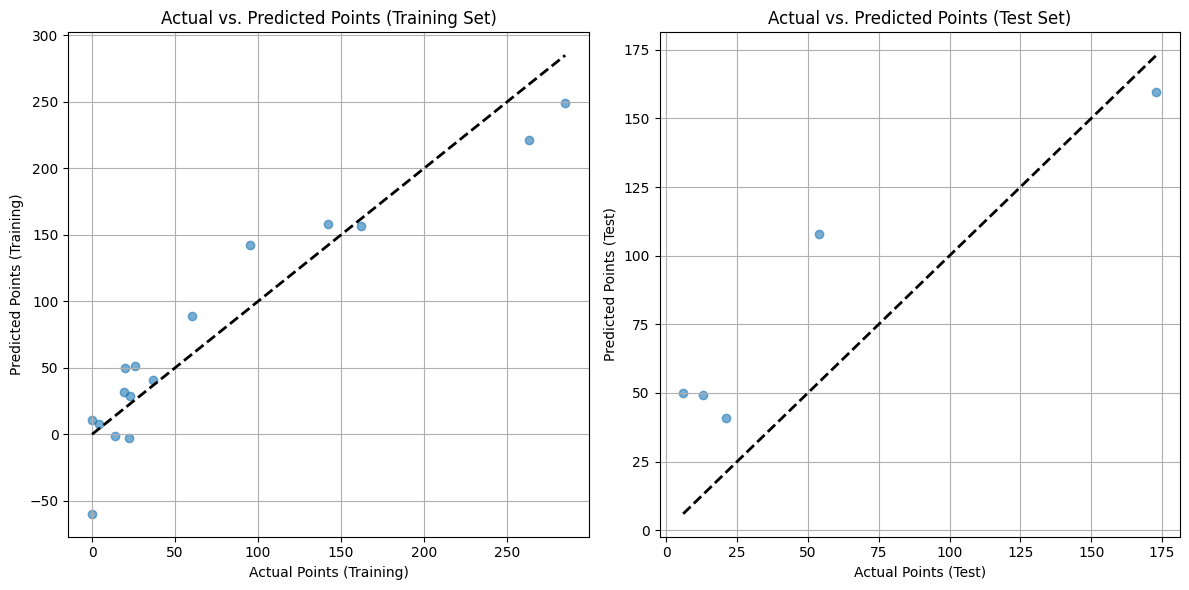

In [19]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred, alpha=0.6)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', lw=2)
plt.xlabel("Actual Points (Training)")
plt.ylabel("Predicted Points (Training)")
plt.title("Actual vs. Predicted Points (Training Set)")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Points (Test)")
plt.ylabel("Predicted Points (Test)")
plt.title("Actual vs. Predicted Points (Test Set)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
data['Predicted_Points'] = model.predict(X)
data.sort_values(by='Predicted_Points', ascending=False, inplace=True)
display(data[['Driver', 'Predicted_Points', 'Total Points']].head(10))

,Driver,Predicted_Points,Total Points
12,Lando Norris,248.914233,285.0
18,Oscar Piastri,221.209700,263.0
15,Max Verstappen,159.717097,173.0
2,Charles Leclerc,157.866341,142.0
7,George Russell,156.418403,162.0
13,Lewis Hamilton,142.415367,95.0
0,Alexander Albon,108.052091,54.0
10,Kimi Antonelli,89.004958,60.0
4,Fernando Alonso,51.009526,26.0
14,Liam Lawson,49.889261,20.0


## **Constructors Championship Prediction**

In [56]:
df.head()

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Set Fastest Lap,Fastest Lap Time,Fastest Lap In Seconds
0,Australia,1.0,4,Lando Norris,McLaren Mercedes,1,57.0,1:42:06.304,25.0,Yes,1:22.167,82.167
1,Australia,2.0,1,Max Verstappen,Red Bull Racing Honda RBPT,3,57.0,+0.895,18.0,No,1:23.081,83.081
2,Australia,3.0,63,George Russell,Mercedes,4,57.0,+8.481,15.0,No,1:25.065,85.065
3,Australia,4.0,12,Kimi Antonelli,Mercedes,16,57.0,+10.135,12.0,No,1:24.901,84.901
4,Australia,5.0,23,Alexander Albon,Williams Mercedes,6,57.0,+12.773,10.0,No,1:24.597,84.597


In [57]:
team_data = df.groupby('Team').agg({
    'Points': 'sum',
    'Fastest Lap In Seconds': 'mean',
    'Position': 'mean',
    'Points' : 'std',
    'Starting Grid': 'mean'
}).reset_index()

In [58]:
team_data = team_data.rename(columns={'Points' : 'Points Stddev', 'Starting Grid': 'Starting Grid Mean'})

total_team_points = df.groupby('Team')['Points'].sum().reset_index()
team_data = team_data.merge(total_team_points, on='Team')
team_data.rename(columns={'Points': 'Total Points'}, inplace=True)



In [65]:
A = team_data[['Starting Grid Mean','Position', 'Points Stddev']]
B = team_data['Total Points']

In [66]:
A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.2, random_state=42)

print("A_train shape:", A_train.shape)
print("B_train shape:", B_train.shape)
print("A_test shape:", A_test.shape)
print("B_test shape:", B_test.shape)

A_train shape: (8, 3)
B_train shape: (8,)
A_test shape: (2, 3)
B_test shape: (2,)


In [67]:
team_model = LinearRegression()
team_model.fit(A_train, B_train)
print("Model Coefficients:", team_model.coef_)
print("Model Intercept:", team_model.intercept_)

Model Coefficients: [ 17.08228859 -67.70318064 -12.72718638]
Model Intercept: 648.0553597462851


In [68]:
b_pred = team_model.predict(A_test)

mae = mean_absolute_error(B_test, b_pred)
mse = mean_squared_error(B_test, b_pred)
r2 = r2_score(B_test, b_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 42.11212880408118
Mean Squared Error: 1817.7320766381363
R-squared: 0.5630714316115291


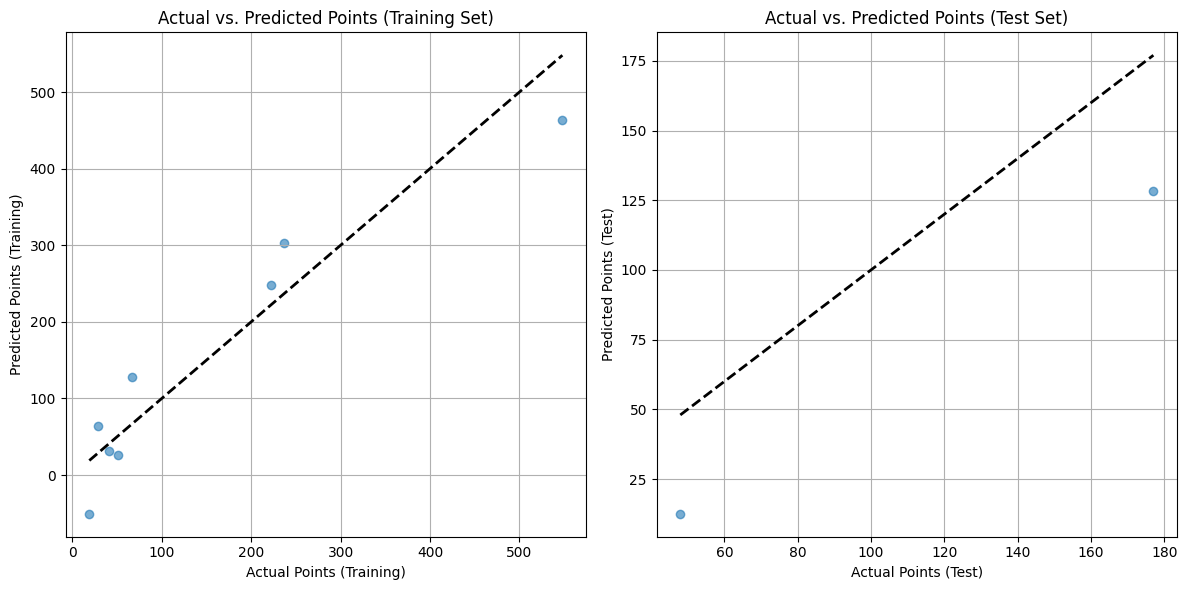

In [69]:
B_train_pred = team_model.predict(A_train)
B_test_pred = team_model.predict(A_test)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(B_train, B_train_pred, alpha=0.6)
plt.plot([B_train.min(), B_train.max()], [B_train.min(), B_train.max()], 'k--', lw=2)
plt.xlabel("Actual Points (Training)")
plt.ylabel("Predicted Points (Training)")
plt.title("Actual vs. Predicted Points (Training Set)")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(B_test, B_test_pred, alpha=0.6)
plt.plot([B_test.min(), B_test.max()], [B_test.min(), B_test.max()], 'k--', lw=2)
plt.xlabel("Actual Points (Test)")
plt.ylabel("Predicted Points (Test)")
plt.title("Actual vs. Predicted Points (Test Set)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [71]:
team_data['Predicted_Points'] = team_model.predict(A)
team_data.sort_values(by='Predicted_Points', ascending=False, inplace=True)
display(team_data[['Team', 'Predicted_Points', 'Total Points']].sort_values(by='Predicted_Points', ascending=False).head(10))

,Team,Predicted_Points,Total Points
5,McLaren Mercedes,464.019378,548.0
2,Ferrari,302.430215,237.0
6,Mercedes,248.462011,222.0
8,Red Bull Racing Honda RBPT,128.231995,177.0
9,Williams Mercedes,127.707732,67.0
3,Haas Ferrari,64.533622,29.0
7,Racing Bulls Honda RBPT,31.300015,41.0
4,Kick Sauber Ferrari,26.076804,51.0
1,Aston Martin Aramco Mercedes,12.543747,48.0
0,Alpine Renault,-50.529778,19.0
